# Feature Engineering


### TF-IDF on detail_desc


In [1]:
import sys
sys.path.append('../') 
from hnm_data_analysis.feature_engineering import ArticleDescriptionVectoriser

vec = ArticleDescriptionVectoriser(
    input_path="../data/cleaned/articles_last_3_months_cleaned.parquet",
    language="en",
    use_lemmatise=True,
    use_stem=False,
)
tfidf, svd = vec.process(
    output_dir="../data/processed/features",
    include_svd=True,
    svd_components=200,
    max_features=30000, min_df=5, max_df=0.8, ngram_range=(1,2),
)

Loading articles from: ../data/cleaned/articles_last_3_months_cleaned.parquet
Articles with valid descriptions: 42,229
Prepared cleaned texts: 42,229
Fitting TF-IDF: max_features=30000, min_df=5, max_df=0.8, ngram_range=(1, 2)
TF-IDF shape: 42,229 docs x 11,309 terms
Fitting TruncatedSVD with n_components=200 ...
SVD embeddings shape: 42,229 x 200
Saving TF-IDF matrix to: ../data/processed/features/tfidf_features.npz
Saving vectorizer to: ../data/processed/features/vectorizer.joblib
Saving article_id index to: ../data/processed/features/article_id_index.csv
Saving SVD embeddings to: ../data/processed/features/svd_embeddings.parquet
Saving SVD model to: ../data/processed/features/svd_model.joblib


### Categorical Features for Articles


In [ ]:
# Now let's create categorical features from the articles data
from hnm_data_analysis.feature_engineering.categorical_features import ArticleCategoricalEncoder

# Initialise the categorical encoder
cat_encoder = ArticleCategoricalEncoder(
    input_path="../data/cleaned/articles_last_3_months_cleaned.parquet",
    encoding_strategy="mixed",  # Use mixed strategy (one-hot + label encoding)
    handle_rare_categories="group",  # Group rare categories as "Other"
    rare_threshold=0.001  # Categories below 0.1% frequency are considered rare
)

# Load data and fit the encoders
cat_encoder.load_data()
categorical_features = cat_encoder.fit_transform(scale_features=True)

# Save the categorical features
cat_encoder.save_features("../data/processed/categorical_features")

print(f"Categorical features shape: {categorical_features.shape}")
print(f"Feature names (first 10): {cat_encoder.feature_names[:10]}")


Loading articles from: ../data/cleaned/articles_last_3_months_cleaned.parquet
Loaded 42,298 articles with 28 columns
Found 12 categorical columns: ['product_code', 'prod_name', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no', 'index_code', 'index_group_no', 'section_no', 'garment_group_no']
Dropping product_code: too many unique values (20981)
Dropping prod_name: too many unique values (21219)
Encoding config: 7 one-hot, 3 label, 0 ordinal
Grouped 4 rare categories in graphical_appearance_no as 'Other'
Grouped 8 rare categories in colour_group_code as 'Other'
Grouped 2 rare categories in perceived_colour_value_id as 'Other'
Grouped 3 rare categories in perceived_colour_master_id as 'Other'
One-hot encoded 7 columns into 131 features
Grouped 61 rare categories in product_type_no as 'Other'
Grouped 80 rare categories in department_no as 'Other'
Grouped 8 rare categories in section_no as 'Other'


### Combining TF-IDF and Categorical Features


In [3]:
# Combine TF-IDF and categorical features for comprehensive clustering
from hnm_data_analysis.feature_engineering.categorical_features import CombinedFeatureProcessor

# Initialise the combined feature processor
combiner = CombinedFeatureProcessor(
    tfidf_dir="../data/processed/features",  # Where we saved TF-IDF features
    categorical_dir="../data/processed/categorical_features"  # Where we saved categorical features
)

# Combine features with custom weights
# You can adjust these weights based on your needs:
# - Higher tfidf_weight emphasises text description similarity
# - Higher categorical_weight emphasises product attribute similarity
combined_features = combiner.combine_features(
    tfidf_weight=0.7,  # 70% weight to text features
    categorical_weight=0.3  # 30% weight to categorical features
)

# Save combined features for clustering
combiner.save_combined_features("../data/processed/combined_features")

print(f"Combined features shape: {combined_features.shape}")
print(f"Number of articles: {len(combiner.article_ids)}")


Loaded TF-IDF features: 42,229 x 11,309
Loaded categorical features: 42,298 x 134
Found 42,229 common articles between TF-IDF and categorical features
Combined features shape: 42,229 x 11,443
TF-IDF contribution: 11,309 features (weight: 0.7)
Categorical contribution: 134 features (weight: 0.3)
Saved combined features to: ../data/processed/combined_features/combined_features.npy
Saved article ID index to: ../data/processed/combined_features/combined_article_id_index.csv
Saved metadata to: ../data/processed/combined_features/combined_features_metadata.json
Combined features shape: (42229, 11443)
Number of articles: 42229


### Clustering with Combined Features


In [4]:
# Now let's perform clustering using both text and categorical features
from hnm_data_analysis.clustering.article_clustering import ArticleClusterer, ClusteringConfig

# Initialise the clusterer
clusterer = ArticleClusterer(
    features_path="../data/processed/combined_features/combined_features.npy",
    article_ids_path="../data/processed/combined_features/combined_article_id_index.csv",
    articles_metadata_path="../data/cleaned/articles_last_3_months_cleaned.parquet"
)

# Load features and metadata
clusterer.load_features()
clusterer.load_articles_metadata()

# Find optimal number of clusters using elbow method
optimal_k, scores = clusterer.find_optimal_k(k_range=(3, 15), algorithm="kmeans")

print(f"Optimal number of clusters: {optimal_k}")
print(f"Elbow scores: {scores}")


Loaded features: 42,229 articles x 11,443 features
Loaded articles metadata: 42,298 articles
Finding optimal k using elbow method with kmeans...
k=3: elbow score = 234018522.5176
k=4: elbow score = 232806382.8790
k=5: elbow score = 233348696.8180
k=6: elbow score = 233587884.8930
k=7: elbow score = 232748145.4288
k=8: elbow score = 231982911.2523
k=9: elbow score = 232337663.7038
k=10: elbow score = 231619513.4587
k=11: elbow score = 232085306.5644
k=12: elbow score = 232042973.4676
k=13: elbow score = 231016166.2024
k=14: elbow score = 231372737.8858
k=15: elbow score = 231242619.7756
Optimal k selected: 4
Optimal number of clusters: 4
Elbow scores: {3: 234018522.51756263, 4: 232806382.8790062, 5: 233348696.81801268, 6: 233587884.89299577, 7: 232748145.4288289, 8: 231982911.25231272, 9: 232337663.7038025, 10: 231619513.4587164, 11: 232085306.56441978, 12: 232042973.46762383, 13: 231016166.20241052, 14: 231372737.8858178, 15: 231242619.77560213}


In [5]:
# Perform K-means clustering with the optimal number of clusters
config = ClusteringConfig(
    algorithm="kmeans",
    n_clusters=optimal_k,
    random_state=42
)

# Cluster the articles
results = clusterer.cluster(config)

# Interpret the clusters to understand what each cluster represents
cluster_interpretations = clusterer.interpret_clusters()

print(f"\nClustering Results:")
print(f"Algorithm: {results.algorithm}")
print(f"Number of clusters: {results.n_clusters}")
print(f"Silhouette score: {results.silhouette:.4f}")
print(f"Calinski-Harabasz score: {results.calinski_harabasz:.4f}")

# Display cluster summaries
print(f"\nCluster Summaries:")
for cluster_id, summary in cluster_interpretations.items():
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {summary['size']} articles ({summary['percentage']:.1f}%)")
    
    # Show top product groups if available
    if 'top_product_group_name' in summary:
        print(f"  Top product groups: {list(summary['top_product_group_name'].keys())[:3]}")
    
    # Show top colors if available  
    if 'top_colour_group_name' in summary:
        print(f"  Top colors: {list(summary['top_colour_group_name'].keys())[:3]}")


Performing kmeans clustering...
Clustering completed: 4 clusters
Silhouette Score: -0.0219
Calinski-Harabasz Index: 103.4497
Davies-Bouldin Index: 8.8955

Clustering Results:
Algorithm: kmeans
Number of clusters: 4
Silhouette score: -0.0219
Calinski-Harabasz score: 103.4497

Cluster Summaries:

Cluster 0:
  Size: 38277 articles (90.6%)
  Top product groups: ['product_group_name', 'count']
  Top colors: ['colour_group_name', 'count']

Cluster 1:
  Size: 3814 articles (9.0%)
  Top product groups: ['product_group_name', 'count']
  Top colors: ['colour_group_name', 'count']

Cluster 2:
  Size: 11 articles (0.0%)
  Top product groups: ['product_group_name', 'count']
  Top colors: ['colour_group_name', 'count']

Cluster 3:
  Size: 127 articles (0.3%)
  Top product groups: ['product_group_name', 'count']
  Top colors: ['colour_group_name', 'count']


Creating 2D visualization using PCA...


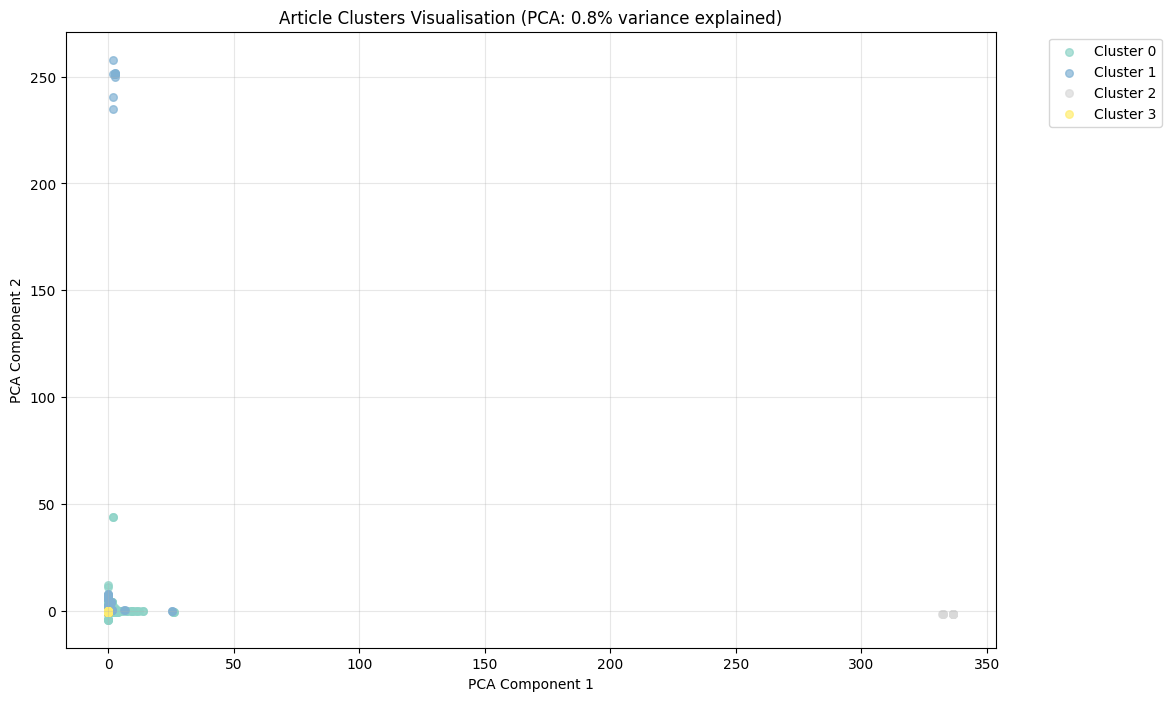

Creating 2D visualization using TSNE...


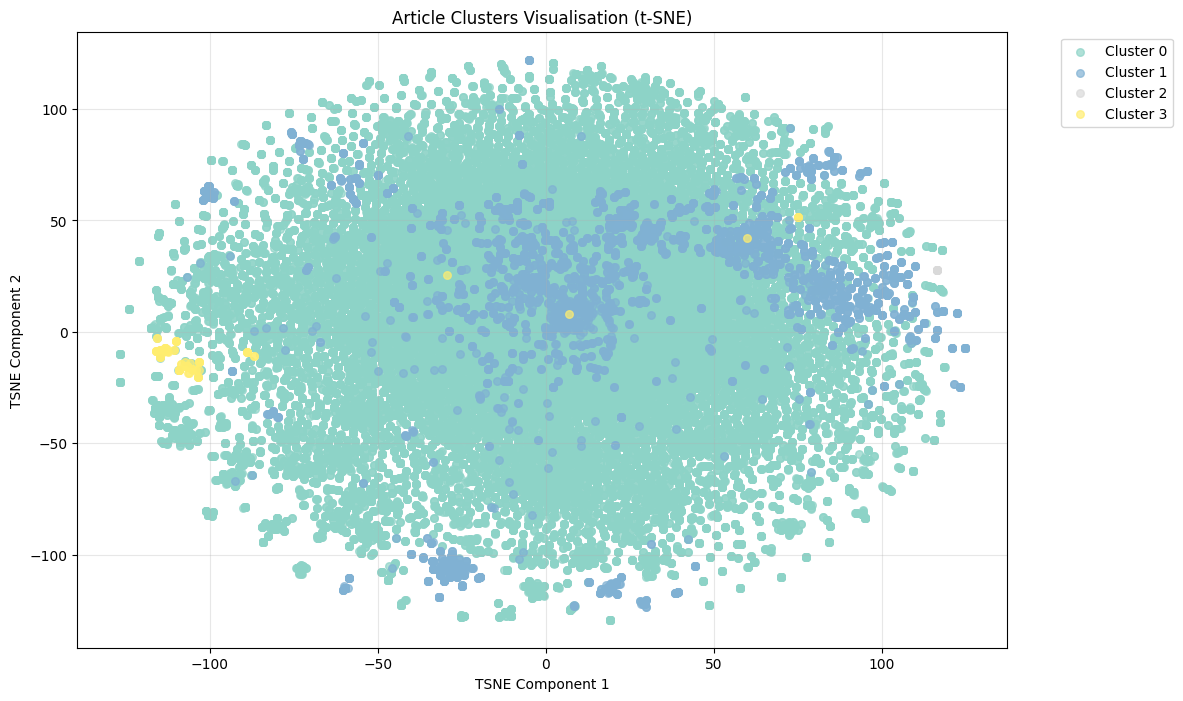

In [6]:
# Visualise the clusters
clusterer.visualise_clusters(method="pca")
clusterer.visualise_clusters(method="tsne")


In [7]:
# Save clustering results for further analysis
clusterer.save_results("../results/clustering")

print("Clustering results saved to ../results/clustering/")
print("Files created:")
print("- cluster_labels.csv: Article IDs with their cluster assignments")
print("- clustering_model.joblib: Trained clustering model") 
print("- clustering_results.json: Clustering metrics and metadata")
print("- cluster_interpretations.json: Detailed cluster analysis")


Saved cluster labels to: ../results/clustering/cluster_labels.csv
Saved clustering model to: ../results/clustering/clustering_model.joblib
Saved results metadata to: ../results/clustering/clustering_results.json


TypeError: Object of type Series is not JSON serializable